In [322]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pymulticonsensus
from kornia.feature import LoFTR
import torch
from time import time
import sys
sys.path.append('../dataset_comparison/')
from utils import draw_soft_assignment, draw_labeling, model_type

In [323]:
#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)

def draw_matches(correspondences, img1, img2, mask = None):    
    if mask is not None:
        matchesMask = mask.ravel().tolist()
    else:
        matchesMask = np.ones(correspondences.shape[0]).ravel().tolist()
    kps1 = []
    kps2 = []
    tentatives = []
    
    for pointIdx in range(correspondences.shape[0]):
        kps1.append(cv2.KeyPoint(correspondences[pointIdx, 0], correspondences[pointIdx, 1], 1))
        kps2.append(cv2.KeyPoint(correspondences[pointIdx, 2], correspondences[pointIdx, 3], 1))
        tentatives.append(cv2.DMatch(pointIdx, pointIdx, 0, 0))
    
    img_out = cv2.drawMatches(decolorize(img1), kps1, decolorize(img2), kps2, tentatives, None)
    plt.figure(figsize = (12,8))
    plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
    plt.show() 
    return

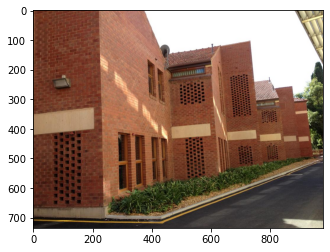

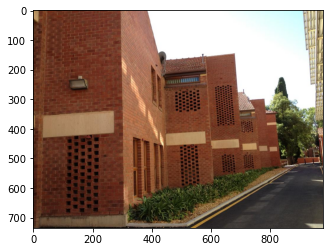

In [324]:
# Load the images
img1 = cv2.cvtColor(cv2.imread('../build/data/unihouse/unihouse1.png'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('../build/data/unihouse/unihouse2.png'), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.figure()
plt.imshow(img2)

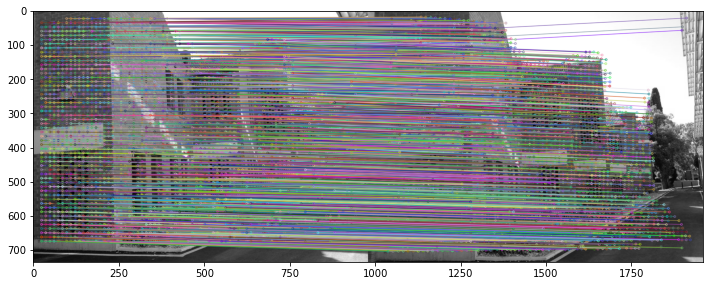

In [325]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
matcher = LoFTR(pretrained='outdoor').to(device)

gray_img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
gray_img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
img1_raw = cv2.resize(gray_img1, (640, 480))
img2_raw = cv2.resize(gray_img2, (640, 480))

inputs = {
    'image0': torch.tensor(img1_raw, dtype=torch.float, device=device)[None, None] / 255.,
    'image1': torch.tensor(img2_raw, dtype=torch.float, device=device)[None, None] / 255.
}
with torch.no_grad():
    pred = matcher(inputs)
    pred = {k: v.cpu().numpy() for k, v in pred.items()}
    
mkpts0, mkpts1 = pred['keypoints0'], pred['keypoints1']
mkpts0[:, 0] = (img1.shape[1] / 640) * mkpts0[:, 0]
mkpts0[:, 1] = (img1.shape[0] / 480) * mkpts0[:, 1]
mkpts1[:, 0] = (img2.shape[1] / 640) * mkpts1[:, 0]
mkpts1[:, 1] = (img2.shape[0] / 480) * mkpts1[:, 1]

confidences = pred['confidence']
correspondences = np.concatenate([mkpts0, mkpts1], axis=1)

# Order the correspondences by confidence
indices = np.argsort(confidences)[::-1]
confidences = confidences[indices]
correspondences = correspondences[indices, :]

draw_matches(correspondences, img1, img2)

In [326]:
def get_homographies(img1, img2, correspondences, inlier_threshold = 1.0):    
    homographies = pymulticonsensus.findHomographies(
        np.ascontiguousarray(correspondences), 
        img1.shape[1], img1.shape[0], 
        img2.shape[1], img2.shape[0],
        threshold = inlier_threshold,
        confidence = 0.999,
        maximum_tanimoto_similarity = 0.75,
        starting_hypothesis_number = 10,
        added_hypothesis_number = 10,
        max_iters = 75,
        minimum_point_number = 12,
        sampler_id = 1)  
    return np.array(homographies)

In [330]:
t = time()

inlier_threshold = 1.5
homographies = get_homographies(img1, img2, correspondences, inlier_threshold)
model_number = int(homographies.shape[0] / 3)

print ('Time = ', time()-t, ' sec')
print ('Models found = {}'.format(model_number))

Time =  0.40789318084716797  sec
Models found = 13


Drawing a soft labeling


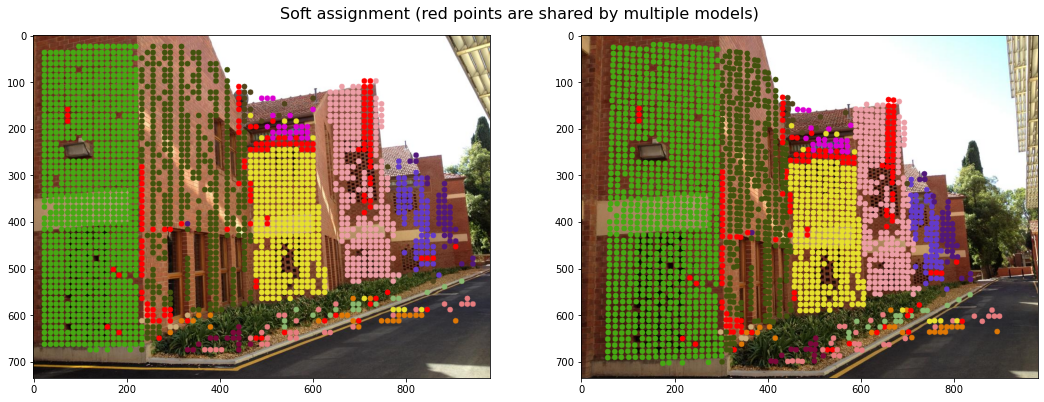

In [331]:
print("Drawing a soft labeling")
soft_assignment = pymulticonsensus.getSoftLabeling(
	homographies.reshape(model_number, 9),
	correspondences,
	model_type("homography"),
	inlier_threshold)
draw_soft_assignment(img1, img2, soft_assignment, correspondences, radius=6, figsize=(18,12))

Drawing a hard labeling determined by PEARL


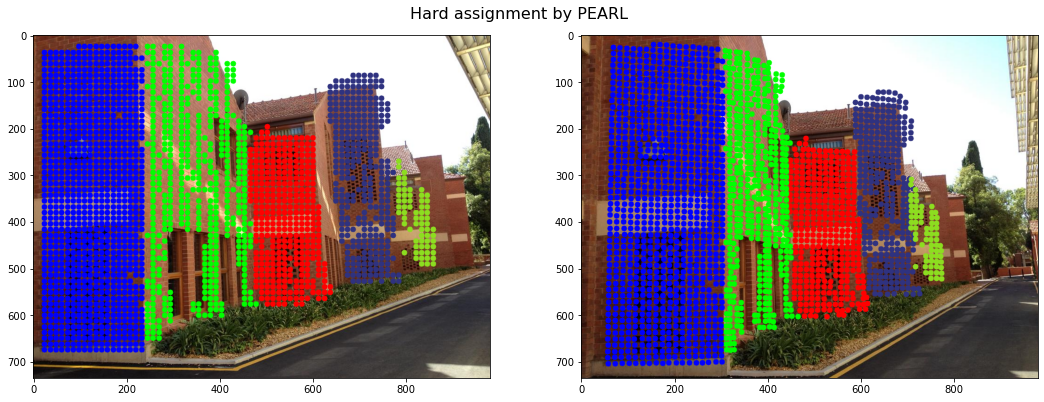

In [341]:
print("Drawing a hard labeling determined by PEARL")
# Get hard labeling by a energy-based labeling of PEARL
if model_number > 0:
    labeling = pymulticonsensus.getLabeling(
        homographies.reshape(model_number, 9), # Esimated models
        correspondences, # Point correspondences
        model_type("homography"), # Model type
        inlier_threshold, # Inlier-outlier threshold
        20.0, # Neighborhood size 
        0.0, # Spatial coherence weight
        12) # Label cost (i.e., minimum number of inliers)
    
    # The estimator returns -1 as the outlier class.
    # In the drawing function, the outlier label is <model #> + 1
    mask = labeling == -1
    labeling[mask] = model_number
else:
    labeling = np.zeros((correspondences.shape[0], 1))
    
draw_labeling(img1, img2, labeling, correspondences, radius=6, figsize=(18,12))